# HW1 : Regression, Cross-Validation, and  Regularization

In [174]:
import os
import numpy as np
import pandas as pd
 
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model

In [175]:
from matplotlib import pyplot as plt

import seaborn as sns
#This sets the default style for all figures. 
sns.set('notebook', font_scale=1.25, style='whitegrid')

### Configuration

You may need to adjust your data directory to point towards the auto data. 

In [209]:
SEED = 12345 

DATA_DIR = '/Users/student/Documents/cs135/cs135-24f-assignments/hw1/data_auto'

# Helper Functions

These notebook sections contain helper functions which you **do not need to alter**.  

### Methods for loading dataset

In [177]:
def load_2d_arr_from_csv(fname, include_header=False):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    assert x.ndim == 2
    if include_header:
        header_cols = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', dtype=str)[0].tolist()
        return x, header_cols
    else:
        return x
    
def load_1d_arr_from_csv(fname):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    if x.ndim == 1:
        return x
    else:
        raise ValueError("Not 1d")

### Plotting methods

In [178]:
def plot_train_and_valid_error_vs_hyper(
        hyper_list, err_tr_list=None, err_va_list=None,
        ymax=40,
        leg_loc='upper right',
        xlabel='polynomial degree',
        ylabel='RMSE'):
    if err_va_list is not None:
        plt.plot(hyper_list, err_va_list, 'rs-', label='valid');
    if err_tr_list is not None:
        plt.plot(hyper_list, err_tr_list, 'bd:', label='train');
    plt.ylim([0, ymax]);
    plt.legend(loc=leg_loc);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);

### Method to sanitize predictions

For many regression problems certain values might be impossible or improbable (such as in this case where we can't have a negative miles-per-gallon). However, most machine learning models cannot learn these types of strict rules. Thus, a common practice in ML is to **sanatize** predictions made by a model, confining them to be within reasonable bounds. 

Here we are predicting MPG, which should 
* (1) always be positive, and
* (2) will probably never exceed 120% of the largest value we see in train data

All model predictions should be sanitized before being used. 

In [179]:
def sanitize(yhat_N):
    yhat_N = np.maximum(yhat_N, 0)
    yhat_N = np.minimum(yhat_N, Y_MAX)
    return yhat_N

## Methods for building pipelines

These are sklearn pipelines, which define a series of steps that can then be treated as if they were a single classifier.  

In [180]:
def make_poly_linear_regr_pipeline(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

In [181]:
def make_poly_ridge_regr_pipeline(degree=1, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

## Method to inspect learned weights

Use this function when asked to display learned parameters.

In [182]:
def pretty_print_learned_weights(pipeline, xcolnames_F):
    ''' Print the learned parameters of given pipeline
    '''
    my_lin_regr = pipeline.named_steps['linear_regr']

    feat_names = pipeline.named_steps['poly_transformer'].get_feature_names_out()
    coef_values = my_lin_regr.coef_

    for feat, coef in zip(feat_names, coef_values):
        print("% 7.2f : %s" % (coef, feat))
    
    print("where ")
    for ff, colname in enumerate(xcolnames_F):
        print("x%d = %s" % (ff, colname))

# Analysis

The rest of this notebook is an analysis and report of the automobile dataset. Some of the steps of the analysis have already been completed for you. You need to complete the indicated sections in problems 1-3.

# Load the dataset

First, we need to load the predefined 'x' and 'y' arrays for train/valid/test sets using the predefined helper function. 

In [183]:
x_tr_MF, xcolnames_F = load_2d_arr_from_csv('x_train.csv', include_header=True)
x_va_NF = load_2d_arr_from_csv('x_valid.csv')
x_te_PF = load_2d_arr_from_csv('x_test.csv')

In [184]:
y_tr_M = load_1d_arr_from_csv('y_train.csv')
y_va_N = load_1d_arr_from_csv('y_valid.csv')
y_te_P = load_1d_arr_from_csv('y_test.csv')

We can then take at various parts of our training data. 

In [185]:
# Feature names
print("Feature Names:", xcolnames_F) 

# First 5 instances in our training data
print("Training data features:\n", x_tr_MF[:5])

# MPG for the first 5 instances
print("Training data MPGs:\n", y_tr_M[:5,np.newaxis])

Feature Names: ['horsepower', 'weight', 'cylinders', 'displacement']
Training data features:
 [[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 [ 105. 3897.    6.  250.]
 [ 193. 4732.    8.  304.]]
Training data MPGs:
 [[28.8]
 [16.5]
 [14. ]
 [16. ]
 [ 9. ]]


Also, we need to set a `Y_MAX` variable so that the sanatize function works. 

In [186]:
# Highest MPG in the training data
y_tr_M.max()

np.float64(46.6)

In [187]:
Y_MAX = y_tr_M.max()*1.2

## Load completed code

Now we load in the code you wrote in part of of the homework. 

In [210]:
from performance_metrics import calc_root_mean_squared_error
from cross_validation import train_models_and_calc_scores_for_n_fold_cv

# Problem 1: Polynomial Degree Selection on Fixed Validation Set

**Implementation Step 1A:**

Fit a linear regression model to a polynomial feature transformation of the provided training set at each of these possible degrees: [1, 2, 3, 4, 5, 6, 7]. For each hyperparameter setting, record the training set error and the validation set error in terms of RMSE.

In [189]:
degree_list = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list = []
fv_err_va_list = []

fv_pipeline_list = []
for degree in degree_list:

    # TODO create a pipeline using features with current degree value
    pipeline = make_poly_linear_regr_pipeline(degree=degree)
    # TODO train this pipeline on provided training data
    pipeline.fit(x_tr_MF, y_tr_M)
    # Compute training error
    yhat_tr_M = sanitize(pipeline.predict(x_tr_MF))
    yhat_va_N = sanitize(pipeline.predict(x_va_NF))

    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M)
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N)

    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)
    
    fv_pipeline_list.append(pipeline)

### Implementation 1B: Score on the test set using the chosen model

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained LinearRegression model with these best hyperparameters, compute error on the *test* set. Save this test set error value for later.

In [190]:
min_index = fv_err_va_list.index(min(fv_err_va_list))
min_Param = degree_list[min_index]

fv_pipeline = fv_pipeline_list[min_index]

yhat_te_PF = sanitize(fv_pipeline.predict(x_te_PF))

fv_error = calc_root_mean_squared_error(y_te_P, yhat_te_PF)

In [191]:
print("Selected Parameters:")
print(min_Param)
print("Fixed validation set estimate of heldout error:")
print(fv_err_va_list[min_index])
print("Error on the test-set:")
print(fv_error)

Selected Parameters:
2
Fixed validation set estimate of heldout error:
3.9740753307545353
Error on the test-set:
3.991502546456764


In [192]:
min_err_tr = fv_err_tr_list[minParam-1]

### Figure 1: Error vs degree

Once `fv_err_tr_list` and `fv_err_va_list` contain values from part 1A, you can re-run the plotting cell to generate figure 1 with the values you found. 

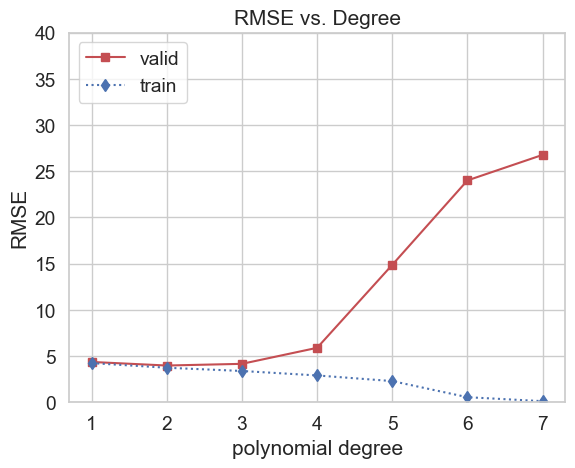

In [193]:
plot_train_and_valid_error_vs_hyper(
    degree_list, fv_err_tr_list, fv_err_va_list, leg_loc='upper left');
plt.title('RMSE vs. Degree');

#### Figure 1: RMSE vs. Degree

*Provide a 2 sentence caption answering the questions: How do validation and training error change as degree increases? What degree do you recommend based on this plot?*

As the degree increases, the RMSE for the training set decreases, where the RMSE of the validation set rapidly increases. I thus recommend polynomial degree 2, since that had the lowest validation set RMSE.

#### Short Answer 1A

The starter code pipelines include a *preprocessing* step that rescales each feature column to be in the unit interval from 0 to 1. 
Why is this necessary for this particular dataset?
What happens (in terms of both training error and test error) if this step is omitted?
*Hint: Try removing this step and see.*

Features need to be rescaled since the different features are within different ranges. As this is a dataset of vehicles, the miles-per-gallon is generally going to be within the 0-30 range, yet the weight in lbs of a truck could be up to 6000. With such varying degrees of magnitude, features must be scaled to a unit interval.

#### Short Answer 1B

Consider the model with degree 1. 
Following the starter code, print out the values of **all** the learned weight parameters (aka coefficients).
From these values, which feature has the highest positive impact on MPG? Which has the highest negative impact? Do these make sense?

In [194]:
# TODO call pretty_print_learned_weights on your pipeline with degree=1 from above
pretty_print_learned_weights(fv_pipeline_list[0], xcolnames_F)
# Hint: The names of the original F=4 features are already in your workspace
#print(xcolnames_F)

 -10.43 : x0
 -18.23 : x1
  -1.15 : x2
   0.58 : x3
where 
x0 = horsepower
x1 = weight
x2 = cylinders
x3 = displacement


Displacement has the highest impact on MPG, weight has the lowest impact on MPG–This makes sense since displacement most likely does not have a big positive nor negative effect on MPG, yet a higher displacement car (more power) could feasibly have more mpg. On the other hand, a heavier car would undoubtedly use more fuel than a lighter car, and is why heavier cars have on average less mpg (negative impact).

# Problem 2: Alpha Selection on Fixed Val Set

#### Implementation Step 2A 

Fix the degree at 4. Consider the below possible `alpha` values for L2-penalized linear regression, aka `Ridge`.

Fit a L2-penalized linear regression pipeline for each alpha value above, then record that model's training set error and the validation set error.

In [195]:
my_degree = 4
alpha_list = np.asarray([1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04, 1.e+06])
print(alpha_list)

[1.e-10 1.e-08 1.e-06 1.e-04 1.e-02 1.e+00 1.e+02 1.e+04 1.e+06]


In [196]:
fv2_err_tr_list = []
fv2_err_va_list = []
fv2_pipeline_list = []

for alpha in alpha_list:

    # TODO create a pipeline using features with current degree value
    pipeline = make_poly_ridge_regr_pipeline(degree=4, alpha=alpha)
    # TODO train this pipeline on provided training data
    pipeline.fit(x_tr_MF, y_tr_M)

    yhat_tr_M = sanitize(pipeline.predict(x_tr_MF))
    yhat_va_N = sanitize(pipeline.predict(x_va_NF))
    assert np.all(yhat_va_N >= 0.0)
    assert np.all(yhat_va_N <= Y_MAX)
    
    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M)
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N)

    fv2_err_tr_list.append(err_tr)
    fv2_err_va_list.append(err_va)

    fv2_pipeline_list.append(pipeline)

### Figure 2 in report

Make a line plot of mean-squared error on y-axis vs. alpha on x-axis.

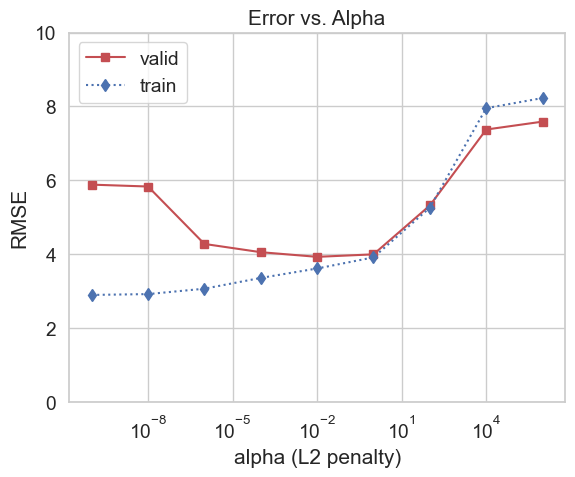

In [197]:
plot_train_and_valid_error_vs_hyper(
    alpha_list, fv2_err_tr_list, fv2_err_va_list,
    xlabel='alpha (L2 penalty)', leg_loc='upper left');
plt.gca().set_ylim([0, 10]);
plt.gca().set_xscale('log');
plt.title('Error vs. Alpha');

#### Figure 2: Error vs. Alpha

Provide a 2 sentence caption answering the questions: How do validation and training set RMSE change with alpha? Do any trends emerge?
What alpha value do you recommend based on this plot?

As alpha rises, the RMSE of the training set always increases–for the validation set, it follows a negative parabola, decreasing then increasing at a negative peak. I would recommend an alpha of 1.e-02, since that is where the validation set RMSE is lowest.

#### Implementation Step 2B

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained model with these best hyperparameters, compute error on the *test* set. 


In [198]:
fv2_min_index = fv2_err_va_list.index(min(fv2_err_va_list))
fv2_min_Param = alpha_list[fv2_min_index]
fv2_pipeline = fv2_pipeline_list[fv2_min_index]

fv2_yhat_te_PF = sanitize(fv2_pipeline.predict(x_te_PF))

fv2_error = calc_root_mean_squared_error(y_te_P, fv2_yhat_te_PF)

In [199]:
print("Selected Parameters:")
print(fv2_min_Param)
print("Fixed validation set estimate of heldout error:")
print(fv2_err_va_list[fv2_min_index])
print("Error on the test-set:")
print(fv2_error)

Selected Parameters:
0.01
Fixed validation set estimate of heldout error:
3.9313878334812444
Error on the test-set:
3.877667860403773


In [200]:
pretty_print_learned_weights(fv2_pipeline_list[fv2_min_index], xcolnames_F)

 -39.88 : x0
   1.56 : x1
  14.71 : x2
 -13.32 : x3
  -6.53 : x0^2
  -5.93 : x0 x1
  21.96 : x0 x2
  24.36 : x0 x3
 -22.82 : x1^2
   2.39 : x1 x2
  -2.18 : x1 x3
 -19.42 : x2^2
 -26.81 : x2 x3
   3.47 : x3^2
   9.93 : x0^3
   5.41 : x0^2 x1
   9.37 : x0^2 x2
  14.07 : x0^2 x3
   8.22 : x0 x1^2
   7.41 : x0 x1 x2
  12.85 : x0 x1 x3
   0.12 : x0 x2^2
  -1.49 : x0 x2 x3
   0.97 : x0 x3^2
  -5.93 : x1^3
  -2.12 : x1^2 x2
  -2.79 : x1^2 x3
   0.19 : x1 x2^2
  -2.80 : x1 x2 x3
  -0.49 : x1 x3^2
  -4.76 : x2^3
  -3.17 : x2^2 x3
   3.10 : x2 x3^2
   5.33 : x3^3
   5.15 : x0^4
  -4.71 : x0^3 x1
  -1.87 : x0^3 x2
   5.64 : x0^3 x3
  -2.97 : x0^2 x1^2
  -5.04 : x0^2 x1 x2
   1.79 : x0^2 x1 x3
 -10.96 : x0^2 x2^2
  -4.93 : x0^2 x2 x3
  -3.79 : x0^2 x3^2
   4.44 : x0 x1^3
   2.40 : x0 x1^2 x2
   5.23 : x0 x1^2 x3
  -4.37 : x0 x1 x2^2
  -0.25 : x0 x1 x2 x3
  -1.68 : x0 x1 x3^2
 -16.61 : x0 x2^3
 -11.02 : x0 x2^2 x3
 -10.19 : x0 x2 x3^2
 -13.04 : x0 x3^3
   2.39 : x1^4
   3.05 : x1^3 x2
   0.24 : x1^

#### Short Answer 2a

Inspect the learned weight parameters of your chosen degree-4 ridge regression model.
How do their relative magnitudes compare to those you printed in 1b above?

There are many more parameters in this model than that shown in 1b–In this model, and the values are much larger. 

#### Short Answer 2b in Report

Your colleague suggests that you can determine the regularization strength `alpha` by minimizing the following loss on the *training* set:

$$
\text{min}_{w \in \mathbb{R}^F, b \in \mathbb{R}, \alpha \ge 0}
\quad \sum_{n=1}^N (y_n - \hat{y}(x_n, w, b))^2 + \alpha \sum_{f=1}^F w_f^2
$$

What value of $\alpha$ would you pick if you did this? Why is this problematic if your goal is to generalize to new data well?

*Hint: Which value of $\alpha$ would minimize this loss function?*

$\alpha$ would be minimized at a value of 0–This is problematic since it eliminates the regularization from the formula, and risks overfitting to the training set.  

# Data preprocessing for Problem 3

For this problem, you'll again use the provided training set and validation sets. However, you'll *merge* these into a large "development" set that contains 292 examples total.

In [201]:
x_trva_LF = np.vstack([x_tr_MF, x_va_NF])
y_trva_L = np.hstack([y_tr_M, y_va_N])

print(x_trva_LF.shape)

(292, 4)


# Problem 3: Cross Validation for Polynomial Feature Regression

### Implementation step 3A

For each possible `alpha` value as well as each possible polynomial degree, train and evaluate a `Ridge` regression model across the entire train+validation set using 10-fold cross validation. Use the CV methods you implemented in `cross_validation.py`. For each possible hyperparameter (alpha value and degree value), your 10-fold CV procedure will give you an estimate of the training error and heldout validation error (averaged across all folds). 


In [211]:
K = 10 # num folds of CV
degree_list = [1, 2, 3, 4, 5, 6, 7]
alpha_list = np.logspace(-10, 6, 17)

ridge_param_list = []
for alpha in alpha_list:
    for degree in degree_list:
        ridge_param_list.append(dict(degree=degree, alpha=alpha))
        
cv_train_err_list = []
cv_valid_err_list = []
for param in ridge_param_list:
    pipeline = make_poly_ridge_regr_pipeline(param["degree"], param["alpha"])
    
    # TODO call your function to train a separate model for each fold and return train and valid errors
    # Don't forget to pass random_state = SEED (where SEED is defined above) so its reproducible
    tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv(estimator=pipeline,
    x_NF=x_trva_LF, y_N=y_trva_L, n_folds=K, random_state=SEED)

    err_tr = np.mean(tr_error_K)
    err_va = np.mean(valid_error_K)
    
    cv_train_err_list.append(err_tr)
    cv_valid_err_list.append(err_va)

### Implementation step 3B

Select the model hyperparameters that *minimize* your estimated cross-validation error. Using these best hyperparameters, retrain the model using the full development set (concatenating the predefined training and validation sets). Then compute that (retrained) model's error on the test set.

Save this test set error value for later.

In [203]:
ridge_min_index = cv_valid_err_list.index(min(cv_valid_err_list))
ridge_min_Param = ridge_param_list[ridge_min_index]

ridge_pipeline = make_poly_ridge_regr_pipeline(ridge_min_Param['degree'], ridge_min_Param['alpha'])
ridge_pipeline.fit(x_trva_LF, y_trva_L)
ridge_yhat_te_PF = sanitize(ridge_pipeline.predict(x_te_PF))

ridge_error = calc_root_mean_squared_error(y_te_P, ridge_yhat_te_PF)

In [204]:
print("Selected Parameters:")
print("degree: ", ridge_min_Param['degree'])
print("alpha: ", ridge_min_Param['alpha'])
print("10-fold CV estimate of heldout error:")
print(min(cv_valid_err_list))
print("Error on the test-set:")
print(ridge_error)

Selected Parameters:
degree:  1
alpha:  1e-10
10-fold CV estimate of heldout error:
0.0
Error on the test-set:
4.148231945864096


 Not exactly sure why the error on this last function is a bit messed up.

### Table 3: Comparing Pipelines on the test set

In one neat table, please compare the *test set* root-mean-squared-error (RMSE) performance for the following regressors:

* Baseline: A predictor that always guesses the *mean* $y$ value of the training set, regardless of the new test input
* The best Poly+Linear pipeline, picking degree to minimize val set error (from 1B)
* The best Poly+Ridge pipeline, fixing degree=4 and picking alpha to minimize val set error (from 2B)
* The best Poly+Ridge pipeline, picking degree and alpha to minimize 10-fold cross validation error (from 3B)

In [205]:
print(fv_err_tr_list[min_index])
print(fv2_err_tr_list[fv2_min_index])
print(min(cv_train_err_list))

3.734676616518151
3.6160483982196947
0.0


TODO make a table in your report using the saved values from 1B, 2B and 3B above. You can fill in the below Markdown table. 

| Name                          | Hyperparameter Value(s)     | Test RMSE | Train RMSE |
|-------------------------------|-----------------------------|-----------|------------|
|      Baseline mean prediction | None                        | 7.104481090304907      | 8.231074409668523       |
|      Poly+Linear pipeine (1B) | Degree = 2               | 3.991502546456764     | 3.734676616518151       |
|  Poly+Ridge Alpha Search (2B) | Degree = 4, Alpha = 0.01    | 3.877667860403773      | 3.6160483982196947      |
| Poly + Ridge Grid Search (3B) | Degree = 1, Alpha = 0.1 | 4.148231945864096      | 0       |


Table 3: 
*Provide a 2-4 sentence caption answering the question: 
What pipeline in Table 3 performed best in terms of heldout error, and why do you thik that pipeline performed the best? 
What pipeline in Table 3 performed worst in terms of heldout error, and why do you thik that pipeline performed the worst?*

I was unfortunately not able to get the Poly Ridge Grid Search to work as intended, yet I would suspect that pipeline would perform the best in heldout error. This pipeline was the result of optimizing hundreds of permutations of different degrees, alpha values, and 10-fold sampling to get an incredibly tweaked pipeline, and would make sense to perform the best. The baseline mean prediction performed the worst simply since it is a mean–it always predicts one value no matter the different factors. It does not describe the data it different points.

## Reflection
Please fill in the following information about your HW1 solution.

How many hours did HW1 take you? 12

Did you use any resources outside of class materials and official documentation, such as StackOverflow threads or ChatGPT? If so, please list such resources below: 
I used StackOverflow to check the syntax of a few rudimentary python functions–array indexing, min(), .index(), etc. 